# Data set de Dígitos
**Sebastián González Juárez**

## Descripción:
En el siguiente notebook vemos la continuación de nuestro aprendizaje para pasar datos de imágenes a qubits, la idea es aprender a implementar los anzants. En este caso usamos las imágenes del conjunto digit data set las cuales tienen una dimensionalidad de (8x8), en este caso reducimos la dimensionalidad a (4x4) por lo que suaremos **16 qubits**. Para poder agilizar el proceso y aprender a realizar las reducciones.

Se incorpora el mismo feacture map y **se muestran 3 ejemplos de anzants** cada uno más complicado que el anterior.

Importaciones:

In [ ]:
!pip install pennylane --quiet

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from math import pi
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
import numpy as np # Make sure to import numpy if not already imported

Idea:

1. La imagen original (8×8).

2. La imagen reducida (ej. 4×4 → 16 valores).

3. El circuito cuántico con un ansatz diferente.

4. La medición final de los qubits.

##  Cargar el dataset Digits

In [ ]:
digits = load_digits()                # Dataset de dígitos 8x8
X = digits.images                     # Imágenes
y = digits.target                     # Etiquetas

## Tomamos una imagen de ejemplo

In [ ]:
idx = 0
img = X[idx]
label = y[idx]

## Mostrar imagen original

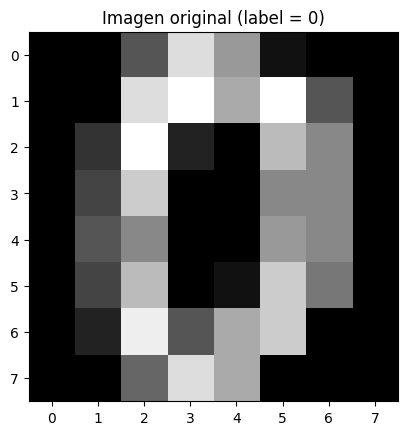

In [ ]:
plt.imshow(img, cmap="gray")
plt.title(f"Imagen original (label = {label})")
plt.show()

## Reducir imagen de 8x8 → 4x4

In [ ]:
img_reduced = resize(img, (4,4), anti_aliasing=True)      # Reducción
scaler = MinMaxScaler((0, np.pi))                         # Escalar intensidades [0,π]
img_flat = scaler.fit_transform(img_reduced.reshape(-1,1)).flatten()  # Aplanar en vector de 16 valores


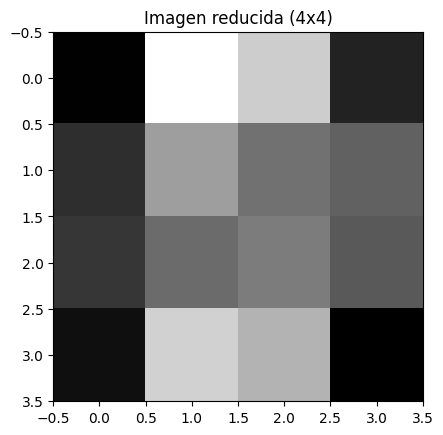

In [ ]:
plt.imshow(img_reduced, cmap="gray")
plt.title("Imagen reducida (4x4)")
plt.show()

Asignamos un qubit a cada pixel:

In [ ]:
n_qubits = len(img_flat)           # Número de qubits = número de píxeles reducidos (16)
dev = qml.device("default.qubit", wires=n_qubits)

# **🔹 Ejemplo 1 – Ansatz con Rotaciones Pauli-X**

## Definir circuito (Feature map + Ansatz 1)

In [ ]:
@qml.qnode(dev)
def circuit_ansatz1(features):
    # ---- Feature Map (codificación de datos) ----
    for i, val in enumerate(features):
        qml.RY(val, wires=i)       # Codifica cada píxel como ángulo en una rotación Y

    # ---- Ansatz 1: Rotaciones Pauli-X ----
    for i in range(n_qubits):
        qml.RX(np.pi/4, wires=i)   # Aplica rotación fija en X para todos los qubits

    # ---- Medición ----
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


## Ejecutar circuito

In [ ]:
result = circuit_ansatz1(img_flat)
print("Mediciones (Ansatz 1):")
print(result)

Mediciones (Ansatz 1):
[np.float64(0.7070291894613948), np.float64(-0.707106781186547), np.float64(-0.5736418689939355), np.float64(0.6443359005554815), np.float64(0.5943942606042479), np.float64(-0.258086469508156), np.float64(0.11502905908255018), np.float64(0.2554755321440962), np.float64(0.5570169089293857), np.float64(0.17809591561134858), np.float64(0.0309379740594789), np.float64(0.31918460118006897), np.float64(0.6945174107225188), np.float64(-0.5928107306017222), np.float64(-0.4158426224611163), np.float64(0.707106781186543)]


In [ ]:
drawer = qml.draw(circuit_ansatz1)
print(drawer(img_flat))

 0: ──RY(0.01)──RX(0.79)─┤  <Z>
 1: ──RY(3.14)──RX(0.79)─┤  <Z>
 2: ──RY(2.52)──RX(0.79)─┤  <Z>
 3: ──RY(0.42)──RX(0.79)─┤  <Z>
 4: ──RY(0.57)──RX(0.79)─┤  <Z>
 5: ──RY(1.94)──RX(0.79)─┤  <Z>
 6: ──RY(1.41)──RX(0.79)─┤  <Z>
 7: ──RY(1.20)──RX(0.79)─┤  <Z>
 8: ──RY(0.66)──RX(0.79)─┤  <Z>
 9: ──RY(1.32)──RX(0.79)─┤  <Z>
10: ──RY(1.53)──RX(0.79)─┤  <Z>
11: ──RY(1.10)──RX(0.79)─┤  <Z>
12: ──RY(0.19)──RX(0.79)─┤  <Z>
13: ──RY(2.57)──RX(0.79)─┤  <Z>
14: ──RY(2.20)──RX(0.79)─┤  <Z>
15: ──RY(0.00)──RX(0.79)─┤  <Z>


# **🔹 Ejemplo 2 – Ansatz con CNOT en cadena**

In [ ]:
@qml.qnode(dev)
def circuit_ansatz2(features):
    # ---- Feature Map ----
    for i, val in enumerate(features):
        qml.RY(val, wires=i)       # Codificación clásica → cuántica

    # ---- Ansatz 2: CNOT en cadena ----
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])   # Entrelaza cada qubit con el siguiente

    # ---- Medición ----
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


## Ejecutar

In [ ]:
result2 = circuit_ansatz2(img_flat)
print("Mediciones (Ansatz 2):")
print(result2)


Mediciones (Ansatz 2):
[np.float64(0.9998902687299617), np.float64(-0.9998902687299617), np.float64(0.8111630913518049), np.float64(0.7391549831929083), np.float64(0.6213339928230529), np.float64(-0.2267803121955949), np.float64(-0.03689163592312389), np.float64(-0.013328835997458599), np.float64(-0.010499668825793396), np.float64(-0.0026445060108288287), np.float64(-0.00011570481367062513), np.float64(-5.2228596570003116e-05), np.float64(-5.1298715583958376e-05), np.float64(4.300684122249265e-05), np.float64(-2.5291905144386728e-05), np.float64(-2.5291905144386728e-05)]


## Dibujo del circuito

In [ ]:
drawer2 = qml.draw(circuit_ansatz2)
print(drawer2(img_flat))

 0: ──RY(0.01)─╭●───────────────────────────────────────────┤  <Z>
 1: ──RY(3.14)─╰X─╭●────────────────────────────────────────┤  <Z>
 2: ──RY(2.52)────╰X─╭●─────────────────────────────────────┤  <Z>
 3: ──RY(0.42)───────╰X─╭●──────────────────────────────────┤  <Z>
 4: ──RY(0.57)──────────╰X─╭●───────────────────────────────┤  <Z>
 5: ──RY(1.94)─────────────╰X─╭●────────────────────────────┤  <Z>
 6: ──RY(1.41)────────────────╰X─╭●─────────────────────────┤  <Z>
 7: ──RY(1.20)───────────────────╰X─╭●──────────────────────┤  <Z>
 8: ──RY(0.66)──────────────────────╰X─╭●───────────────────┤  <Z>
 9: ──RY(1.32)─────────────────────────╰X─╭●────────────────┤  <Z>
10: ──RY(1.53)────────────────────────────╰X─╭●─────────────┤  <Z>
11: ──RY(1.10)───────────────────────────────╰X─╭●──────────┤  <Z>
12: ──RY(0.19)──────────────────────────────────╰X─╭●───────┤  <Z>
13: ──RY(2.57)─────────────────────────────────────╰X─╭●────┤  <Z>
14: ──RY(2.20)────────────────────────────────────────╰X─╭●─┤ 

## **🔹 Ejemplo 3 – Ansatz con Rotaciones + Entrelazamiento completo**

In [ ]:
@qml.qnode(dev)
def circuit_ansatz3(features):
    # ---- Feature Map ----
    for i, val in enumerate(features):
        qml.RY(val, wires=i)       # Codificación clásica → cuántica

    # ---- Ansatz 3: Rotaciones aleatorias ----
    for i in range(n_qubits):
        qml.RZ(np.pi/3, wires=i)   # Rotación en Z
        qml.RX(np.pi/6, wires=i)   # Rotación en X

    # ---- Entrelazamiento completo ----
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            qml.CNOT(wires=[i, j]) # Todos con todos

    # ---- Medición ----
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

## Ejecutar

In [ ]:
result3 = circuit_ansatz3(img_flat)
print("Mediciones (Ansatz 3):")
print(result3)


Mediciones (Ansatz 3):
[np.float64(0.872344964006785), np.float64(-0.7554728996932977), np.float64(0.3891778909450563), np.float64(-0.434781408334169), np.float64(0.9312483459367181), np.float64(0.08378762329636286), np.float64(0.04945526077693524), np.float64(0.4071505956739986), np.float64(0.6800646527656494), np.float64(0.6046427115788535), np.float64(0.29978411707696495), np.float64(0.3657147074188953), np.float64(0.7244132709540012), np.float64(-0.45665651889628145), np.float64(0.07795041385501011), np.float64(-0.1377694723332863)]


## Dibujo del circuito

In [ ]:
drawer3 = qml.draw(circuit_ansatz3)
print(drawer3(img_flat))

 0: ──RY(0.01)──RZ(1.05)──RX(0.52)─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─╭●─────────────── ···
 1: ──RY(3.14)──RZ(1.05)──RX(0.52)─╰X─│──│──│──│──│──│──│──│──│──│──│──│──│──│──╭●─╭●─╭●─╭●─╭● ···
 2: ──RY(2.52)──RZ(1.05)──RX(0.52)────╰X─│──│──│──│──│──│──│──│──│──│──│──│──│──╰X─│──│──│──│─ ···
 3: ──RY(0.42)──RZ(1.05)──RX(0.52)───────╰X─│──│──│──│──│──│──│──│──│──│──│──│─────╰X─│──│──│─ ···
 4: ──RY(0.57)──RZ(1.05)──RX(0.52)──────────╰X─│──│──│──│──│──│──│──│──│──│──│────────╰X─│──│─ ···
 5: ──RY(1.94)──RZ(1.05)──RX(0.52)─────────────╰X─│──│──│──│──│──│──│──│──│──│───────────╰X─│─ ···
 6: ──RY(1.41)──RZ(1.05)──RX(0.52)────────────────╰X─│──│──│──│──│──│──│──│──│──────────────╰X ···
 7: ──RY(1.20)──RZ(1.05)──RX(0.52)───────────────────╰X─│──│──│──│──│──│──│──│──────────────── ···
 8: ──RY(0.66)──RZ(1.05)──RX(0.52)──────────────────────╰X─│──│──│──│──│──│──│──────────────── ···
 9: ──RY(1.32)──RZ(1.05)──RX(0.52)─────────────────────────╰X─│──│──│──│──│──│──────────────── ···
10: ──RY(1